In [1]:
from nameparser import HumanName
import pandas
import numpy
import itertools
import collections
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

### Read the data

In [2]:
data = pandas.read_csv('gr-qc.tsv.xz', compression='xz', sep='\t')

/home/ecm/arxiv-processing/arxiv_proc/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.columns

Index(['Unnamed: 0', 'abstract', 'acm_class', 'arxiv_id', 'author_text',
       'categories', 'comments', 'created', 'doi', 'num_authors',
       'num_categories', 'primary_cat', 'title', 'updated', 'categories_list'],
      dtype='object')

### Filter gravitational wave-related papers and exclude long-author-list collaboration papers

In [4]:
#searchfor = ['gravitational', 'wave']
searchfor = ['gravitational wave']
papers = data[((data['title'].str.contains('|'.join(searchfor))) | \
                  (data['abstract'].str.contains('|'.join(searchfor)))) & \
                  (data['created'].between('2014-01-01','2019-01-01')) & \
                  (data['num_authors'] < 50) & \
                  (data['num_authors'] > 1)]
print("selected {} articles".format(len(papers)))

selected 1818 articles


### Extract and parse author names

In [5]:
names = map(str.strip,','.join(papers['author_text']).split(','))
names = list(set(names)) # remove duplicates
formatted_names = [HumanName(n) for n in names]
print("there are {} authors".format(len(formatted_names)))

there are 3910 authors


### Produce a final, cleaned list of the authors' last names 

In [6]:
last_names = list(set([n.last for n in formatted_names]))  # remove duplicates
last_names.remove('Collaboration') # ad-hoc fix for this type of entry
print("there are {} authors in the cleaned list".format(len(last_names)))

there are 2860 authors in the cleaned list


### Create authors' graph

In [7]:
collaborators = nx.Graph()
collaborators.add_nodes_from(last_names)

### Create edges in graph for co-authors

In [8]:
for index, p in papers.iterrows():
    authors = [HumanName(n).last for n in p['author_text'].split(',')]
    for pair in itertools.combinations(authors, 2):
        collaborators.add_edge(*pair)

In [9]:
print('The collab graph has {} nodes and {} edges'.format(collaborators.number_of_nodes(), \
                                                          collaborators.number_of_edges()))
#print(collaborators.nodes, collaborators.edges)

The collab graph has 2861 nodes and 18290 edges


### Quick view

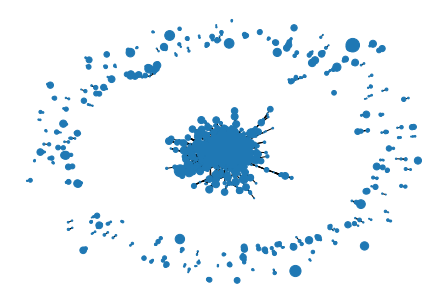

In [16]:
d = dict(collaborators.degree)
nx.draw(collaborators, labelsnodelist=d.keys(), node_size=[v for v in d.values()])

Text(0.5, 0, 'Degree')

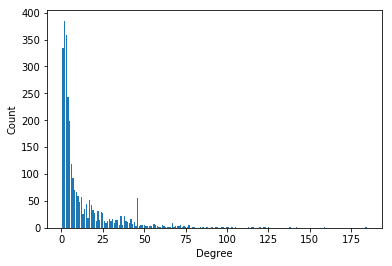

In [17]:
degree_sequence = sorted([d for n, d in collaborators.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
plt.bar(deg, cnt)
plt.ylabel("Count")
plt.xlabel("Degree")

### Export graph to GML file

In [18]:
 nx.write_gml(collaborators, "gw-arxiv.gml")